In [1]:
# Load dataset "compilado_delitos_2022.xlsx" with pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Read the data, all strings
df_copy = pd.read_excel('compilado_delitos_2022.xlsx', dtype=str)


In [2]:
df = df_copy.copy()
#Print dimensions of the dataset
print(df.shape)# Print columns of the dataset
print(df.columns)
# Print the first 5 rows of the data
df.head()

(349804, 42)
Index(['folio', 'origen_incidente', 'fecha_creacion', 'hora_creacion',
       'dia_semana', 'fecha_cierre', 'hora_cierre', 'usuario_inicia',
       'existe_video', 'numero_llamante', 'nombre_llamante',
       'numero_alternativo', 'incidente_c4', 'tipo_intervencion_c2', 'calle',
       'numero', 'esquina', 'colonia', 'codigo_postal', 'delegacion_inicio',
       'sector_inicio', 'c2_inicio', 'latitud', 'longitud', 'senias',
       'codigo_cierre', 'comentarios', 'detenidos', 'tiempo_resp_fce',
       'clas_con_f_alarma', 'tipo_entrada', 'delegacion_cierre',
       'sector_cierre', 'c2_cierre', 'usuario_cierre', 'usuario_intervencion',
       'folio_padre', 't_aten_066', 't_desp_c2_c4', 't_unidad', 't_total',
       'inc-clas'],
      dtype='object')


,folio,origen_incidente,fecha_creacion,hora_creacion,dia_semana,fecha_cierre,hora_cierre,usuario_inicia,existe_video,numero_llamante,...,sector_cierre,c2_cierre,usuario_cierre,usuario_intervencion,folio_padre,t_aten_066,t_desp_c2_c4,t_unidad,t_total,inc-clas
0,C5/20220402/02038,LLAMADA DEL 911,2022-04-02,1899-12-31 07:52:10,Sábado,2022-04-02,1899-12-31 12:35:40,C51098712,NaN,5577358197,...,CUAUTEPEC,C2 Norte,CN827335,CN827335,-,NaN,2.4305555555555552E-4,2.1412037037037038E-3,3.0439814814814821E-3,Robo-Vehículo sin Violencia-DELITO DE ALTO IMP...
1,C5/20220414/03517,LLAMADA DEL 911,2022-04-14,1899-12-31 19:55:24,Jueves,2022-04-14,1899-12-31 23:00:08,C51052088,NaN,5561576497,...,TEPEPAN,C4i,JOBSISTEMA,CO940570,-,NaN,4.1666666666666669E-4,1.7708333333333332E-3,2.5925925925925925E-3,Denuncia-Persona Sospechosa-SERVICIO
2,C5/20220407/04287,LLAMADA DEL 911,2022-04-07,1899-12-31 22:10:55,Jueves,2022-04-08,1899-12-31 02:39:15,C51098777,NaN,4494557234,...,ARAGON,C2 Norte,CN834171,CN834171,-,NaN,3.0092592592592595E-4,-:-:-,-:-:-,Robo-Vehiculo con Violencia-DELITO DE ALTO IMP...
3,C5/20220407/04172,LLAMADA DEL 911,2022-04-07,1899-12-31 21:41:51,Jueves,2022-04-08,1899-12-31 05:19:40,C5917313,NaN,5591224649,...,TEZONCO,C4i,JOBSISTEMA,CO1127834,C5/20220407/04188,NaN,9.3750000000000007E-4,3.5069444444444445E-3,5.6134259259259271E-3,Robo-Vehiculo con Violencia-DELITO DE ALTO IMP...
4,C5/20220408/01398,LLAMADA DEL 911,2022-04-08,1899-12-31 11:02:29,Viernes,2022-04-08,1899-12-31 13:55:42,C51098787,NaN,5514788326,...,HUIPULCO-HOSPITALES,C2 Sur,CS828374,CS828374,-,NaN,2.1064814814814813E-3,4.0509259259259258E-4,3.5185185185185185E-3,Robo-Vehículo sin Violencia-DELITO DE ALTO IMP...


In [3]:
''' Save columns and drop the ones that are not needed
       ['fecha_creacion', 'hora_creacion',
       'dia_semana', 'incidente_c4', 'colonia', 'delegacion_inicio',
       'sector_inicio', 'latitud', 'longitud']
'''

# Remove YYYY-MM-DD in field hora_creacion
df['hora_creacion'] = df['hora_creacion'].str[11:13]
# Remove rows with date 2021-12-31
df = df[df.fecha_creacion != '2021-12-31']
df = df[df.fecha_creacion != '2023-01-01']
# Remove YYYY of field fecha_creacion
df['fecha_creacion'] = df['fecha_creacion'].str[5:]
# Save only MM in field fecha_creacion
#df['fecha_creacion'] = df['fecha_creacion'].str[5:7]
# Parse int to name of month in spanish
#df['fecha_creacion'] = df['fecha_creacion'].replace({'01':'01-Enero', '02':'02-Febrero', '03':'03-Marzo', '04':'04-Abril', '05':'05-Mayo', '06':'06-Junio', '07':'07-Julio', '08':'08-Agosto', '09':'09-Septiembre', '10':'10-Octubre', '11':'11-Noviembre', '12':'12-Diciembre'})

columns = ['fecha_creacion', 'hora_creacion',
        'dia_semana', 'incidente_c4', 'colonia', 'delegacion_inicio',
        'sector_inicio', 'latitud', 'longitud']

df = df[columns]



# Print the first 5 rows of the data
df.head()

,fecha_creacion,hora_creacion,dia_semana,incidente_c4,colonia,delegacion_inicio,sector_inicio,latitud,longitud
0,04-02,07,Sábado,Robo-Vehículo sin Violencia,ZONA ESCOLAR,GUSTAVO A. MADERO,CUAUTEPEC,19.540726,-99.1446619
1,04-14,19,Jueves,Denuncia-Persona Sospechosa,SANTA CECILIA TEPETLAPA,XOCHIMILCO,TEPEPAN,19.220329,-99.095439
2,04-07,22,Jueves,Robo-Vehiculo con Violencia,SAN JUAN DE ARAGON VI SECCION,GUSTAVO A. MADERO,ARAGON,19.466062,-99.064584
3,04-07,21,Jueves,Robo-Vehiculo con Violencia,LA PLANTA,IZTAPALAPA,TEZONCO,19.294715,-99.065944
4,04-08,11,Viernes,Robo-Vehículo sin Violencia,EJIDOS DE SAN PEDRO MARTIR,TLALPAN,HUIPULCO-HOSPITALES,19.264921,-99.162166


In [4]:
# Separar los datos por delitos
df_delitos = df.groupby('incidente_c4')

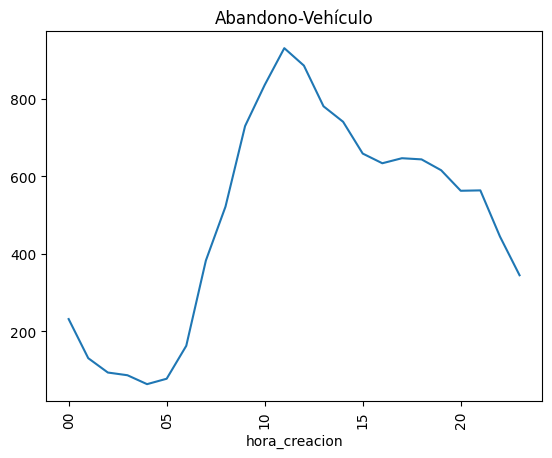

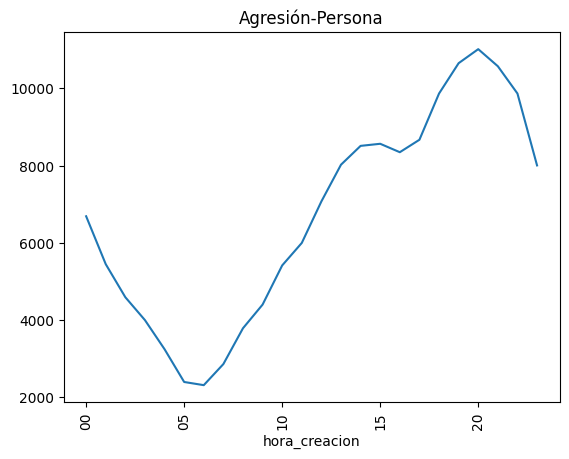

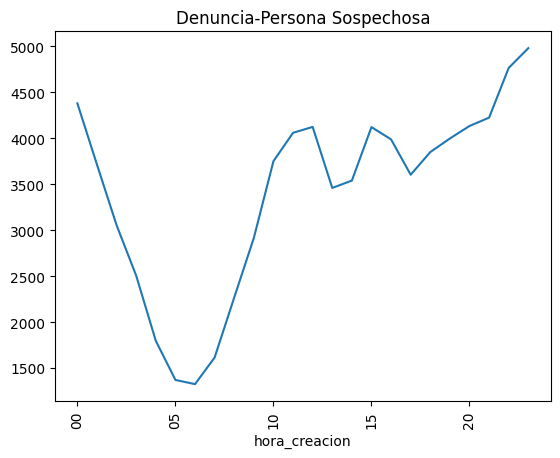

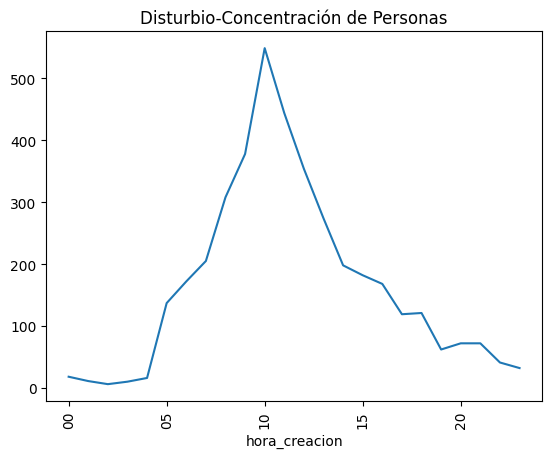

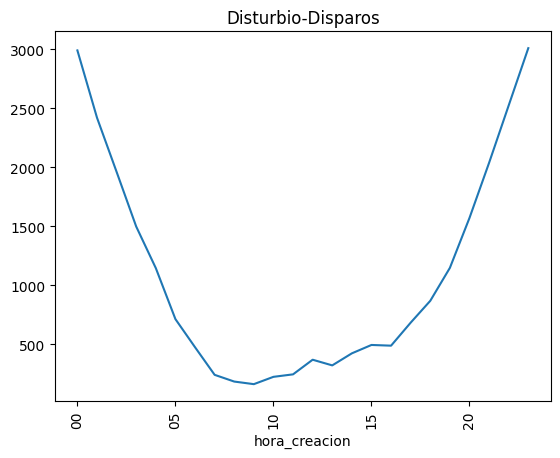

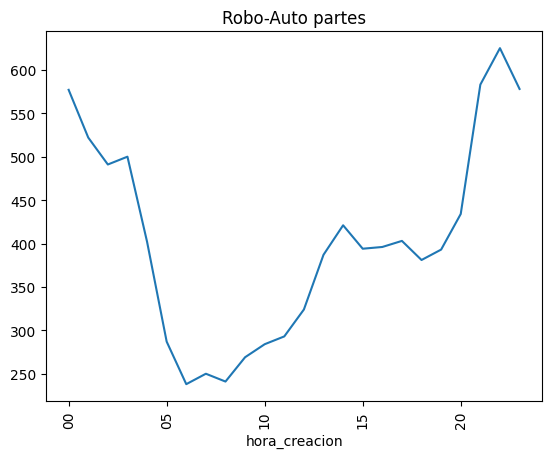

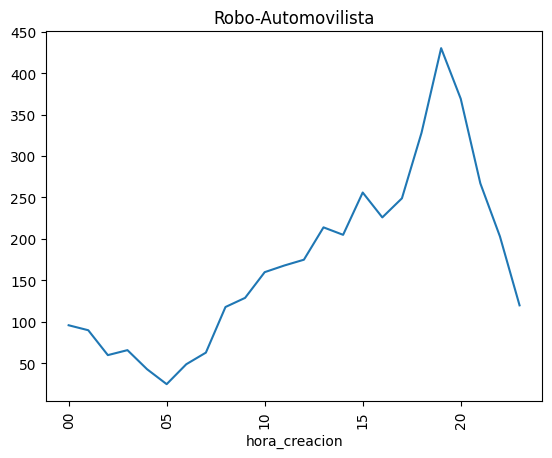

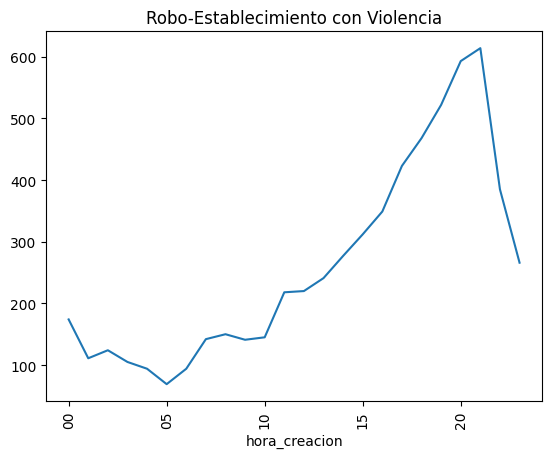

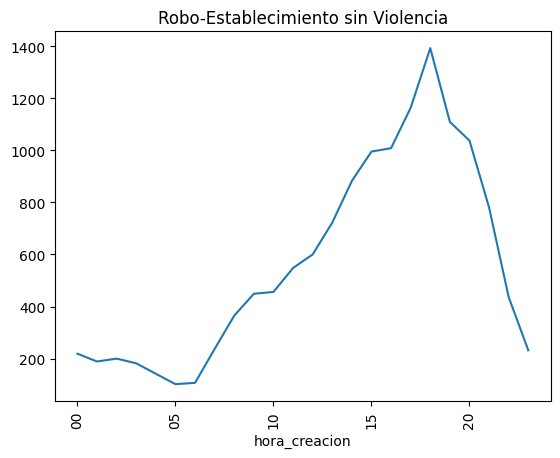

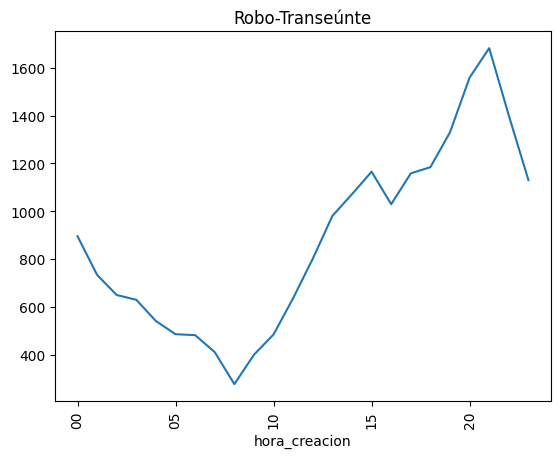

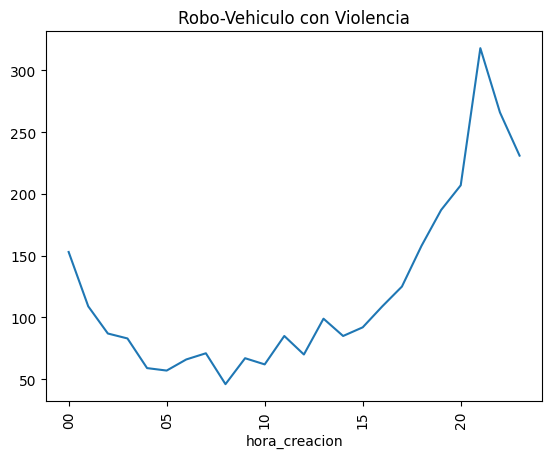

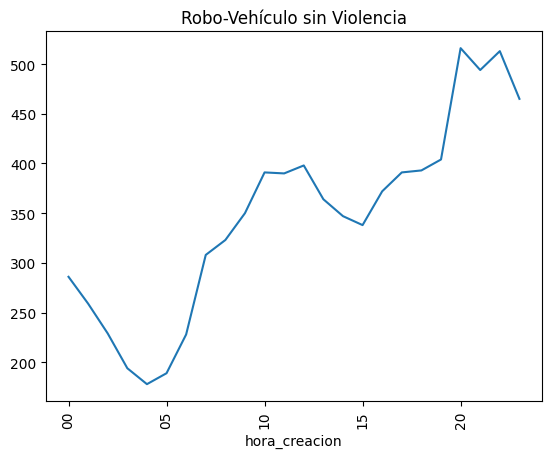

In [5]:
for delito, delito_df in df_delitos:
    delito_df.groupby('hora_creacion').count()['incidente_c4'].plot()
    # Rotate x-labels
    plt.xticks(rotation=90)
    plt.title(delito)
    plt.show()

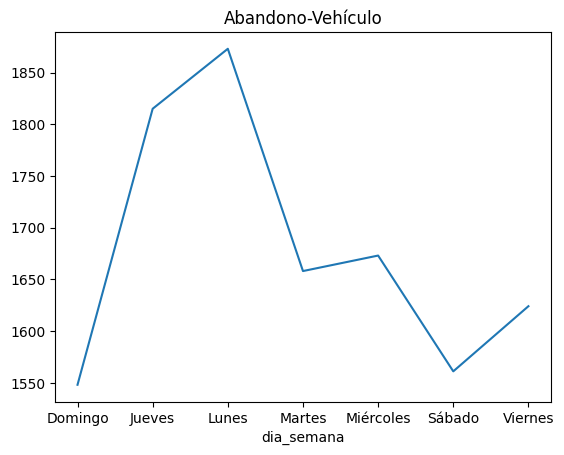

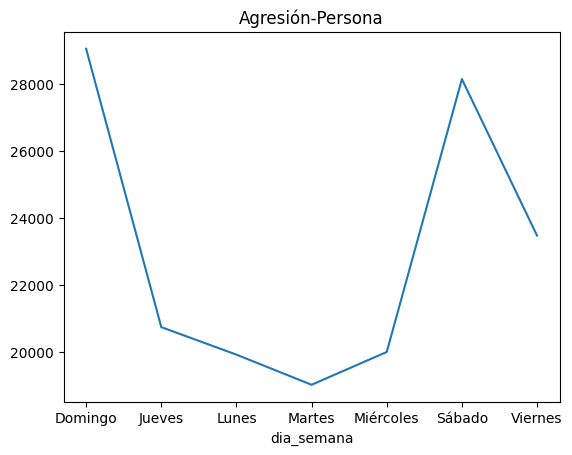

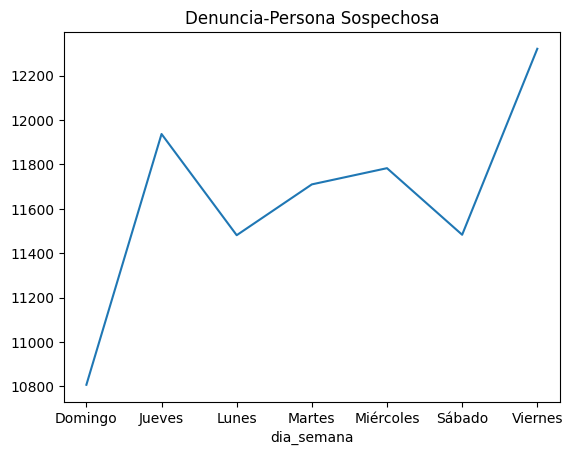

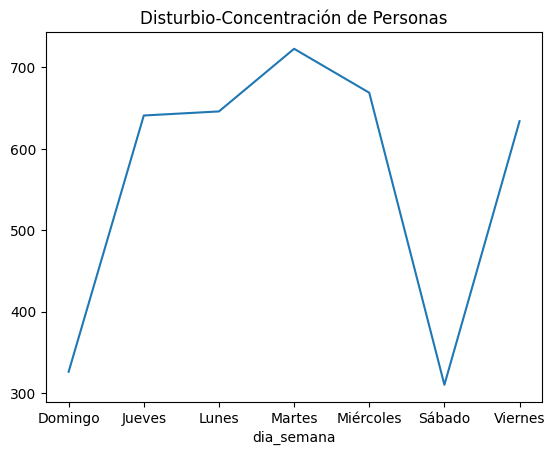

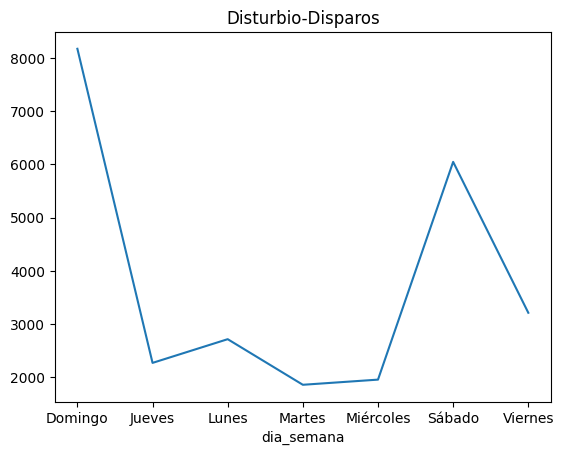

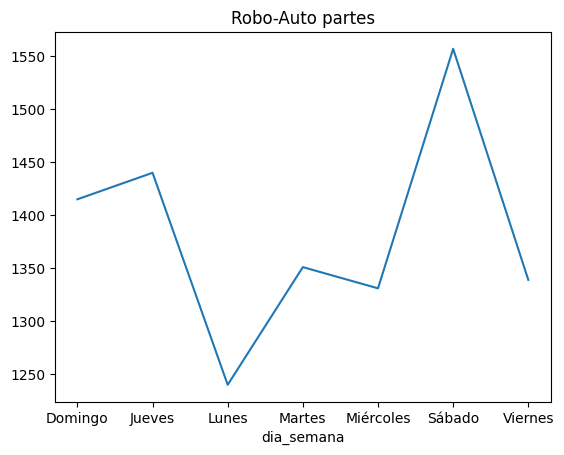

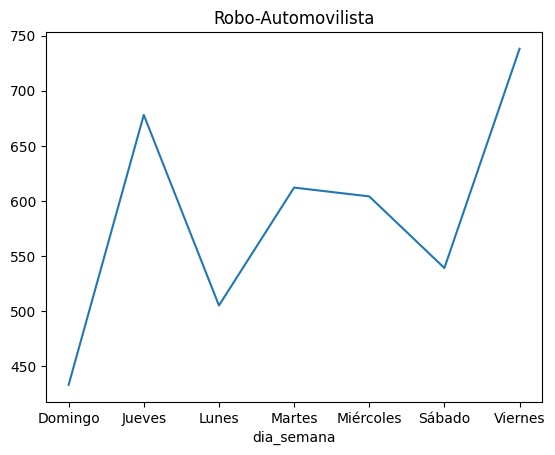

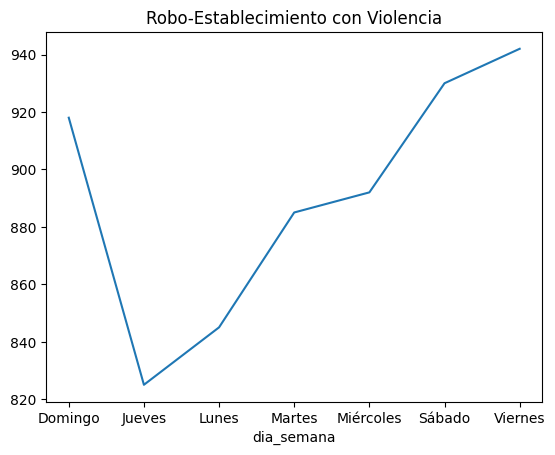

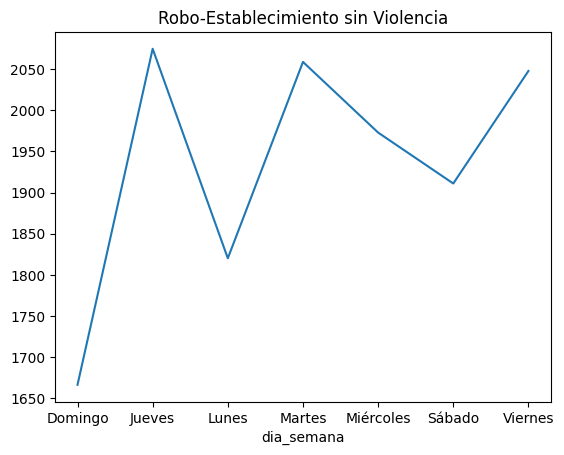

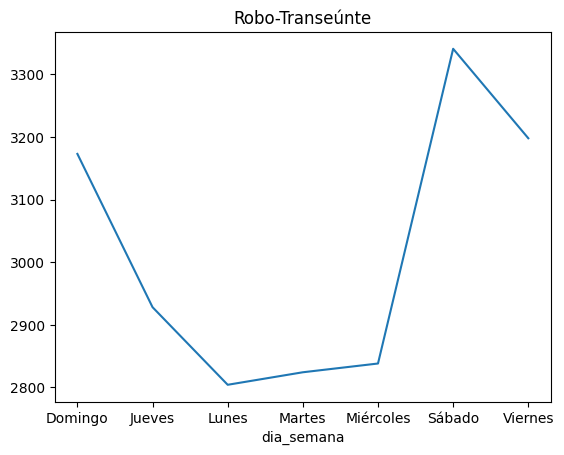

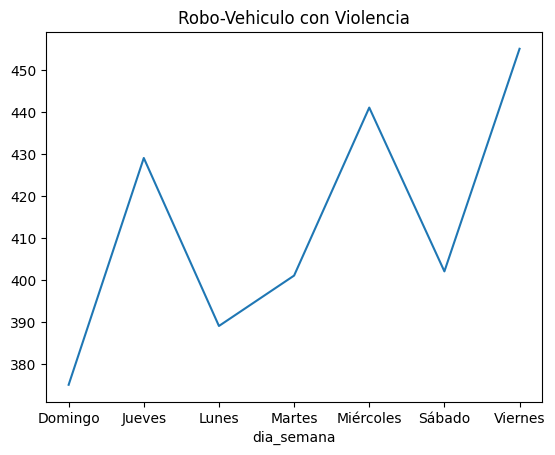

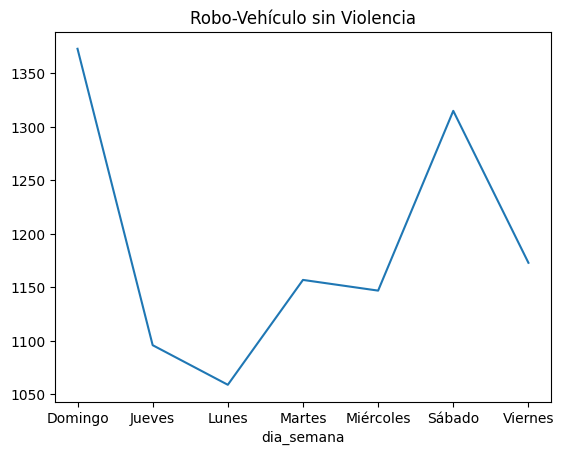

In [6]:
#Ciclo para mostrar la frecuencia temporal de cada delito
for delito, delito_df in df_delitos:
    delito_df.groupby('dia_semana').count()['incidente_c4'].plot()
    plt.title(delito)
    plt.show()


In [12]:
def plottrimestral(delito_df_pt, axes):
    delito_df_pt1 = delito_df_pt
    delito_df_pt1.plot(ax=axes)
    axes.set_title('Enero-Marzo 2022')
    axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
    # Add scatter points with text labels to 5th hights days
    delito_df_pt1_sorted = delito_df_pt1.sort_values(ascending=False)
    for i, (x, y) in enumerate(zip(delito_df_pt1_sorted.index, delito_df_pt1_sorted.values)):
        if i < 5:
            #get position of x in delito_df_pt1
            x_pos = delito_df_pt1.index.get_loc(x)
            axes.scatter(x_pos, y, s=10, color='red')
            axes.text(x_pos, y, str(f"{x} [{y}]"), fontsize=8, color='red', rotation=90)
        elif i+5 >= len(delito_df_pt1_sorted):
            #get position of x in delito_df_pt1
            x_pos = delito_df_pt1.index.get_loc(x)
            axes.scatter(x_pos, y, s=10, color='green')
            axes.text(x_pos, y, str(f"{x} [{y}]"), fontsize=8, color='green', rotation=90,  horizontalalignment='right', verticalalignment='top')
    

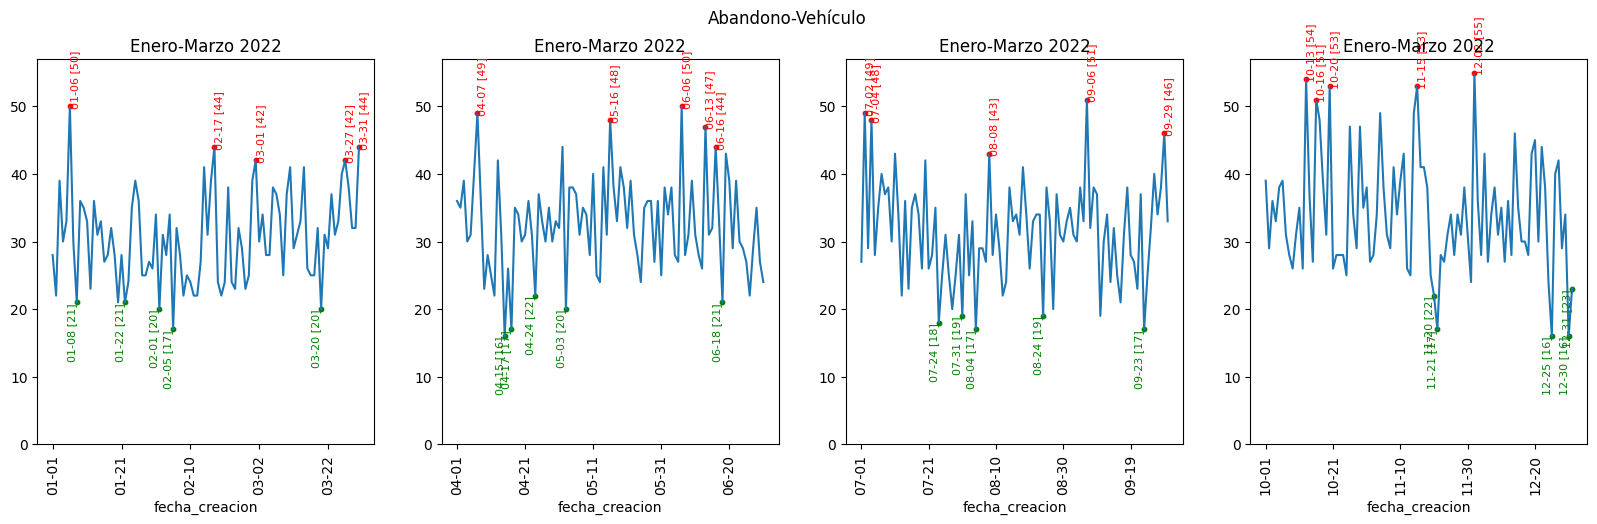

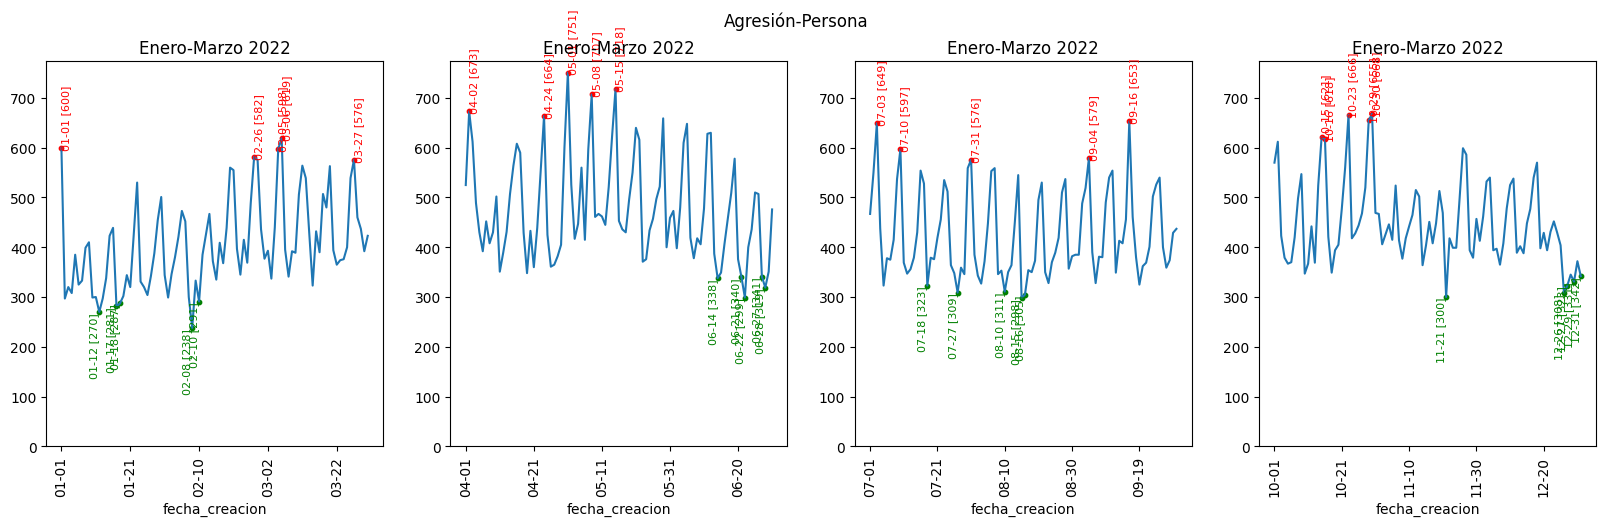

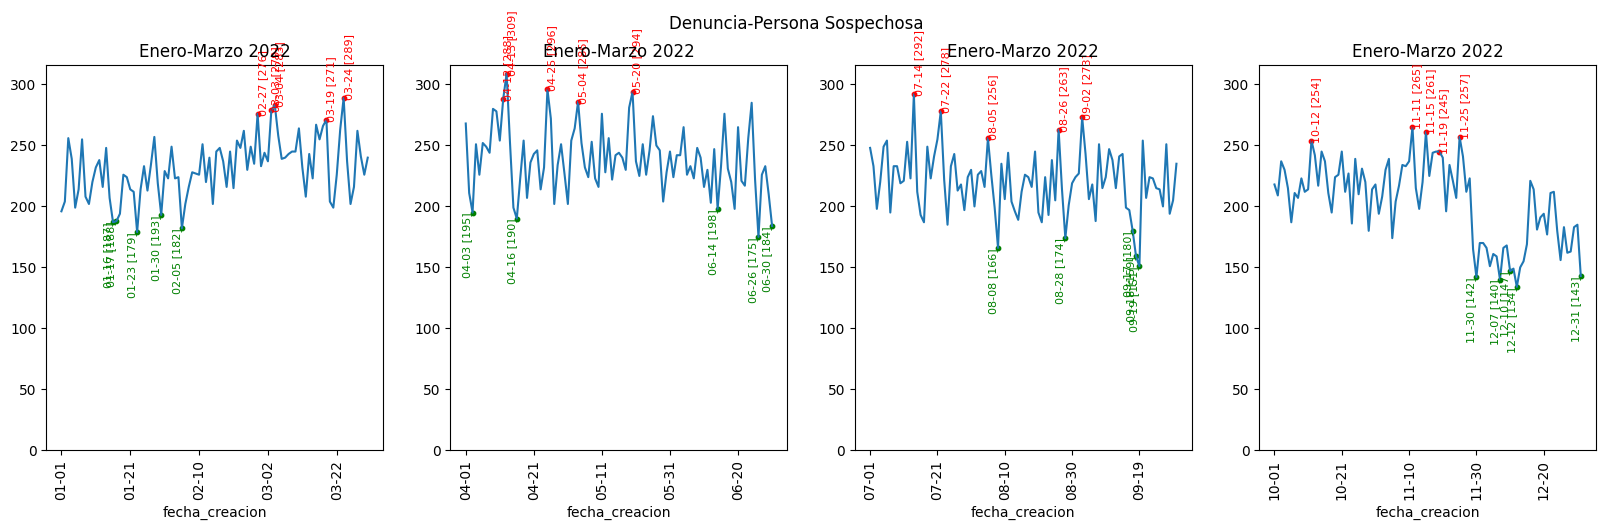

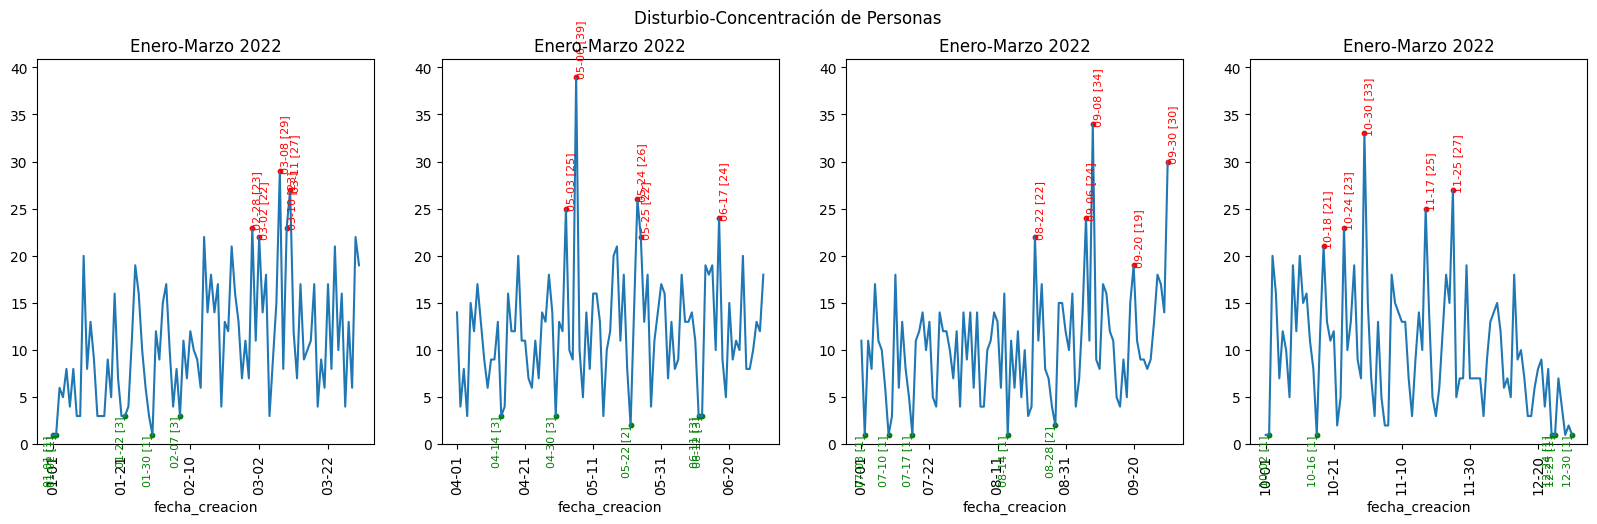

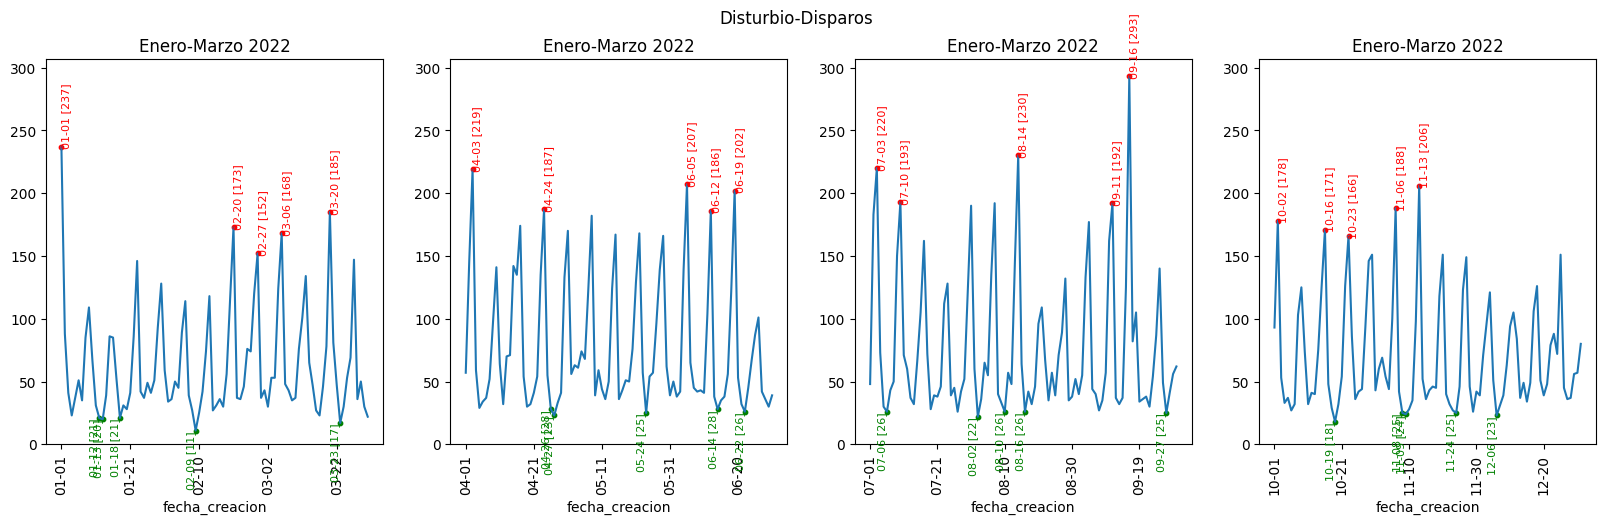

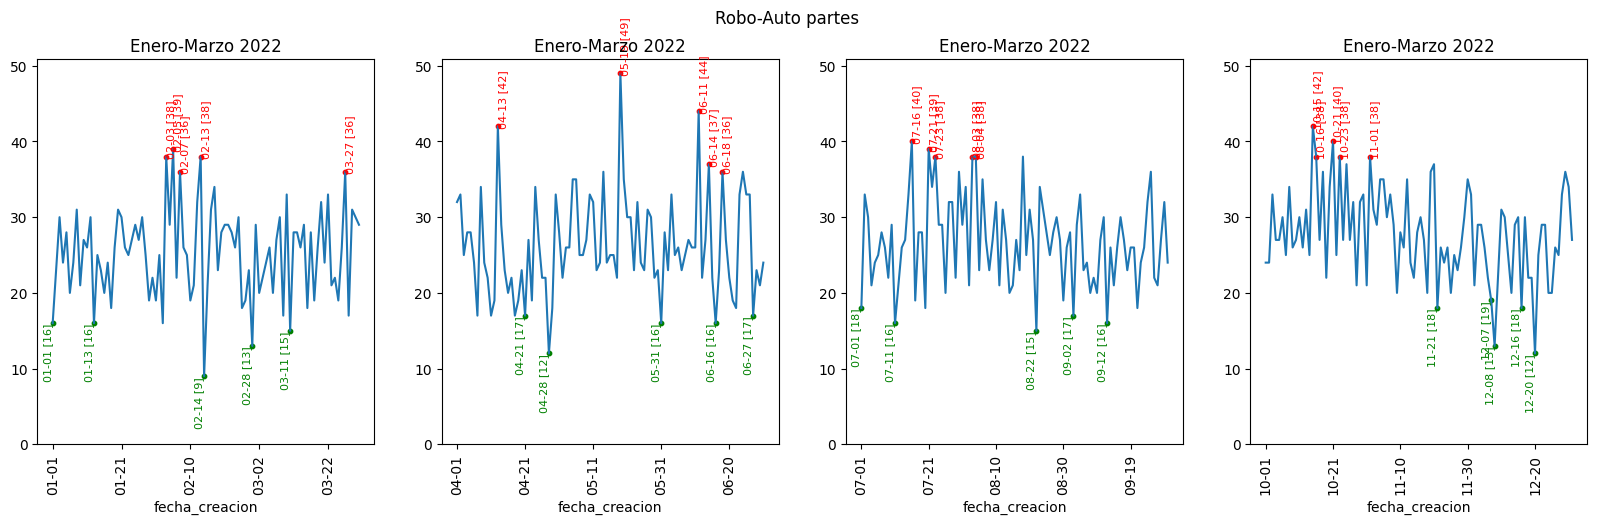

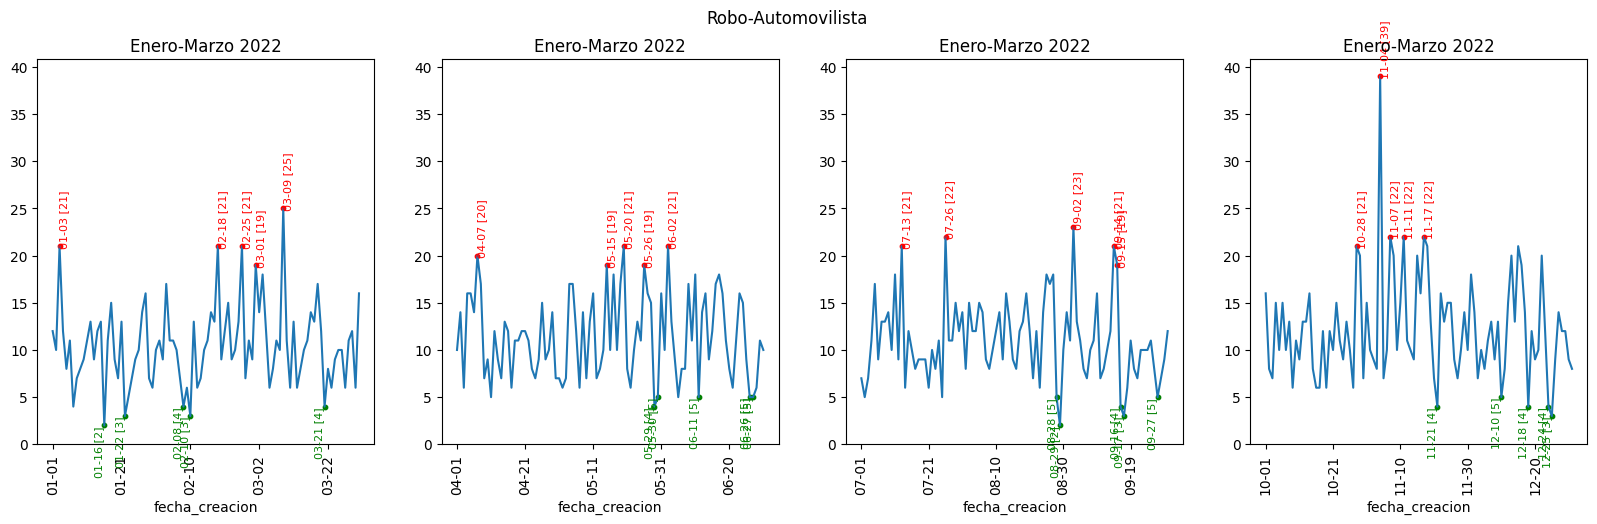

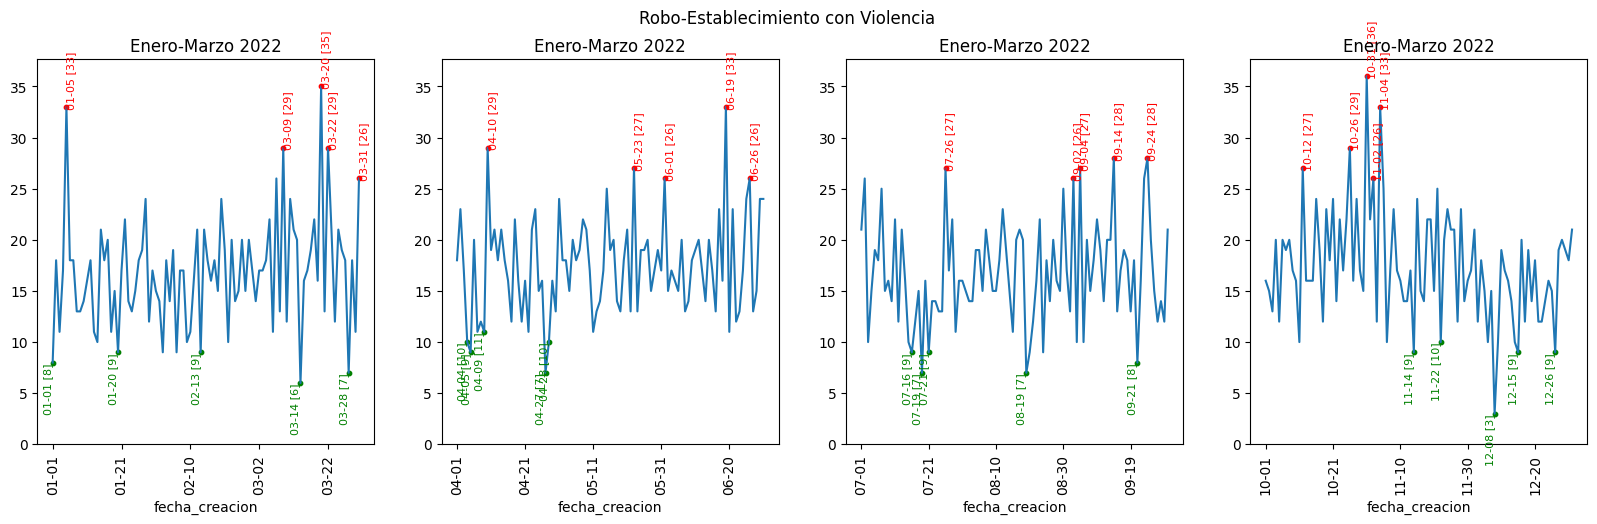

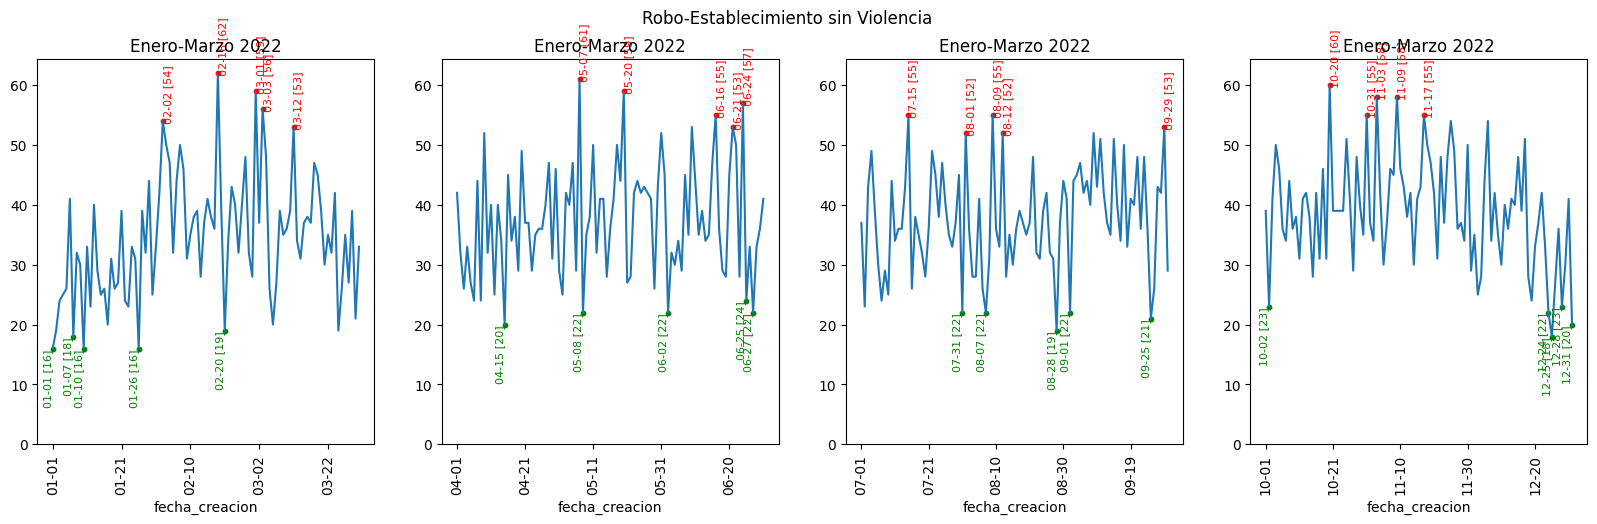

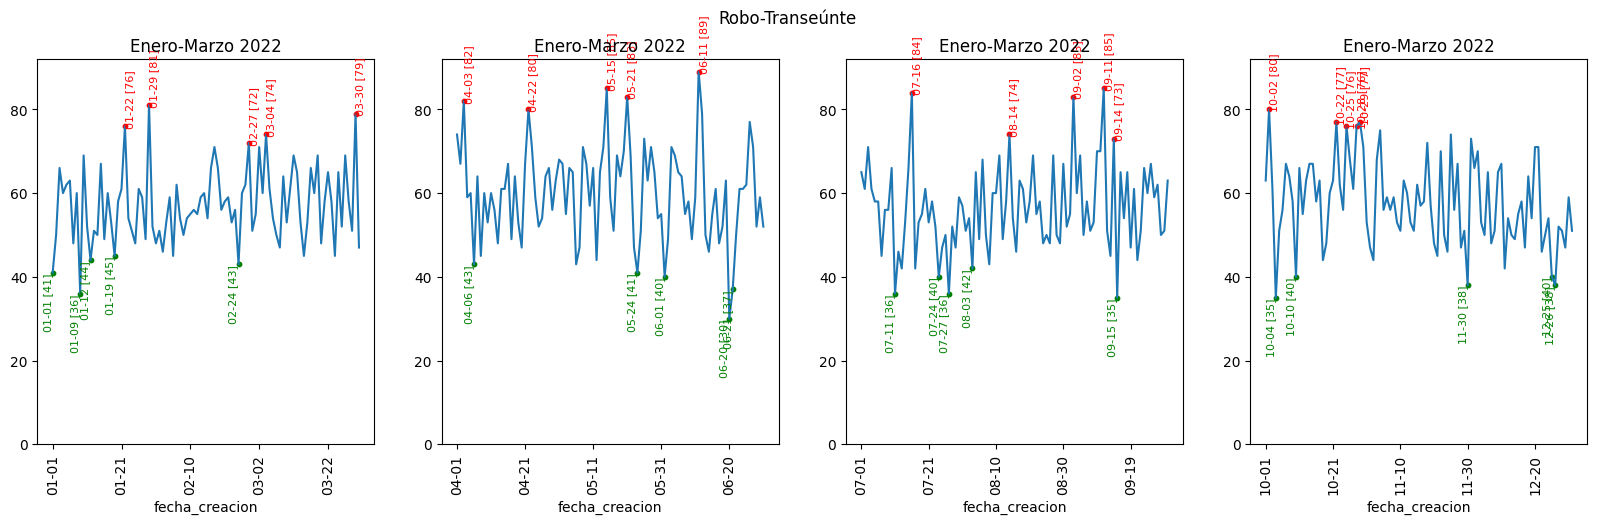

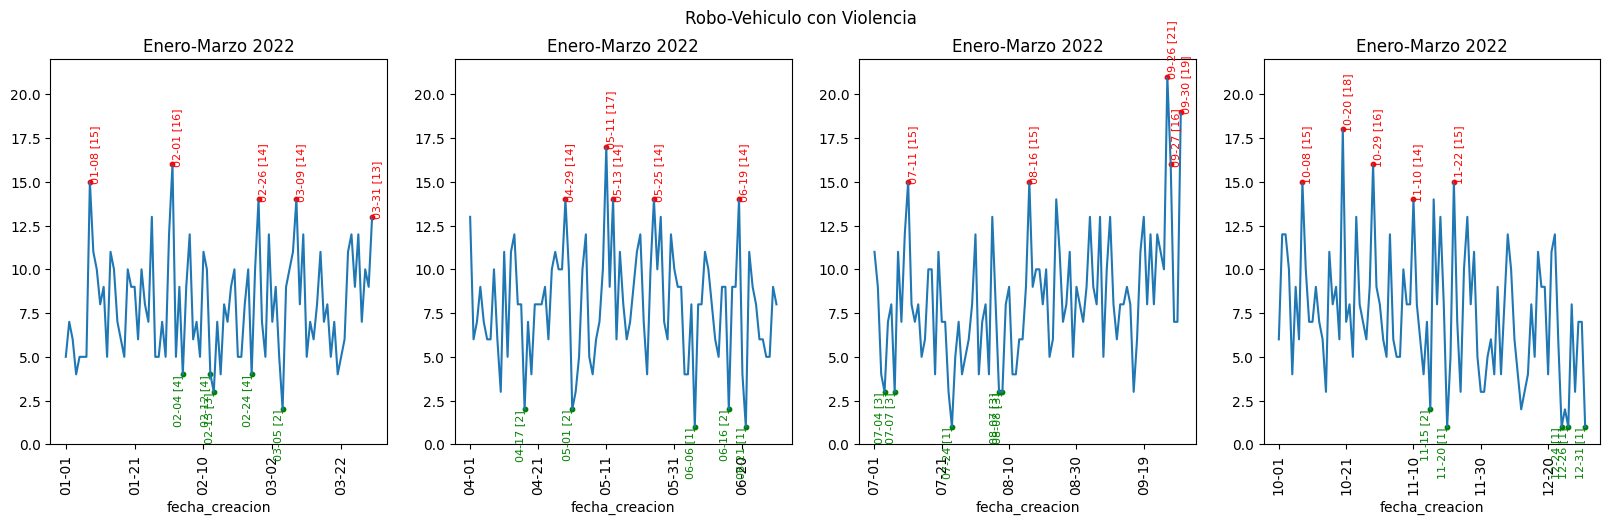

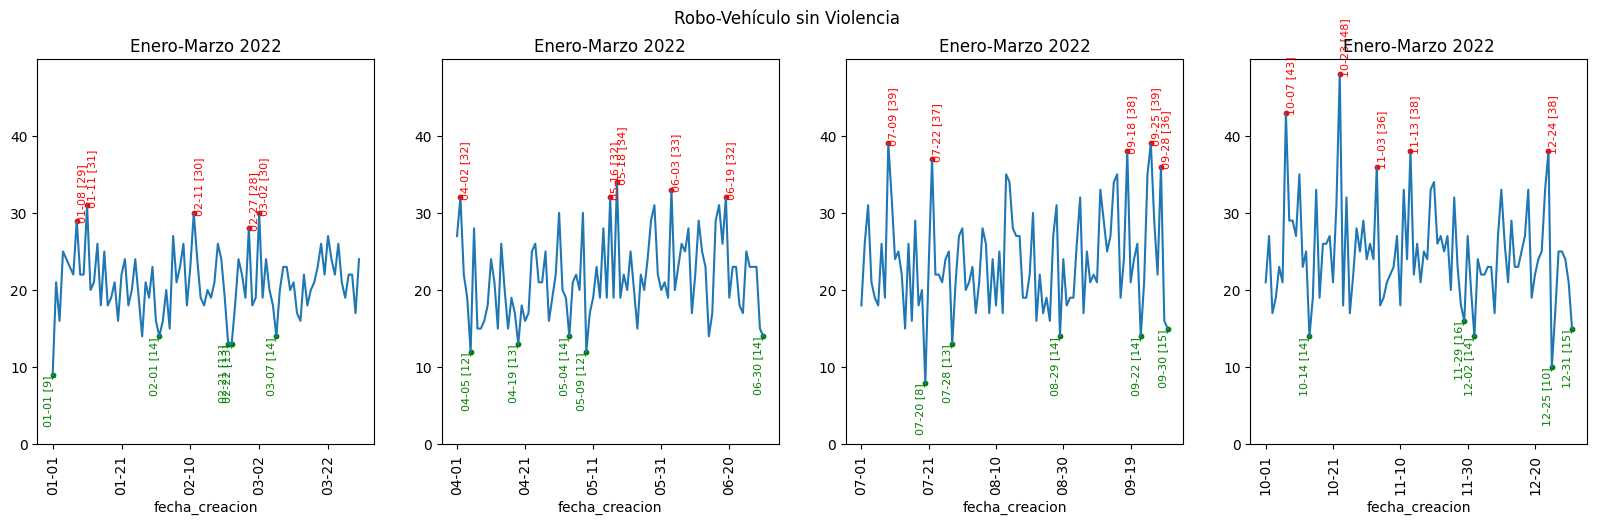

In [15]:
import os
import matplotlib.pyplot as plt

#create dir named tendencia_trimestral if not exists
dir = 'tendencia_trimestral'
if not os.path.exists(dir):
    os.makedirs(dir)
    
with PdfPages(f'{dir}/{dir}.pdf') as pdf:
    for delito, delito_df in df_delitos:
        # A Plot for each 4 months, 3 plots in same row
        fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
        
        delito_df_pt = [delito_df[delito_df['fecha_creacion'] < '04-01'].groupby('fecha_creacion').count()['incidente_c4'], delito_df[(delito_df['fecha_creacion'] >= '04-01') & (delito_df['fecha_creacion'] < '07-01')].groupby('fecha_creacion').count()['incidente_c4'],  delito_df[(delito_df['fecha_creacion'] >= '07-01') & (delito_df['fecha_creacion'] < '10-01')].groupby('fecha_creacion').count()['incidente_c4'], delito_df[(delito_df['fecha_creacion'] >= '10-01')].groupby('fecha_creacion').count()['incidente_c4']]
        
        plottrimestral(delito_df_pt[0], axes[0])
        plottrimestral(delito_df_pt[1], axes[1])
        plottrimestral(delito_df_pt[2], axes[2])
        plottrimestral(delito_df_pt[3], axes[3])
           
        #Get Max scale of all axes using get_ylim()
        y_max = max([ax.get_ylim()[1] for ax in axes])
        #Set all axes to the same scale
        for ax in axes:
            ax.set_ylim(0, y_max)

        plt.suptitle(delito)
        pdf.savefig()
        plt.savefig(f"{dir}/{delito}.png")
        plt.show()

